In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import kagglehub
from typing import List
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import math
from typing import List, Tuple
from collections import Counter
import seaborn as sns

c:\Users\billy\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version of the dataset
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

In [3]:
print(os.listdir(path))

train_df_path =  os.path.join(path, "Train.csv")
test_df_path =  os.path.join(path, "Test.csv")

train_img_path =  os.path.join(path, "Train")
test_img_path =  os.path.join(path, "Test")

['Meta', 'Meta.csv', 'Test', 'Test.csv', 'Train', 'Train.csv']


Much of the following EDA was lifted and/or inspired from Neva's and Gracie's work alongside many kaggle notebooks which have been referenced below, making alterations for ease of use and more thorough analysis.

In [4]:
train_df = pd.read_csv(train_df_path)
test_df = pd.read_csv(test_df_path)

train_df.head()

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png

In [5]:
train_df['ClassId'].value_counts()

ClassId
2     2250
1     2220
13    2160
12    2100
38    2070
10    2010
4     1980
5     1860
25    1500
9     1470
7     1440
3     1410
8     1410
11    1320
35    1200
18    1200
17    1110
14     780
31     780
33     689
15     630
26     600
28     540
23     510
30     450
6      420
16     420
34     420
22     390
36     390
20     360
40     360
21     330
39     300
29     270
24     270
42     240
32     240
27     240
41     240
0      210
19     210
37     210
Name: count, dtype: int64

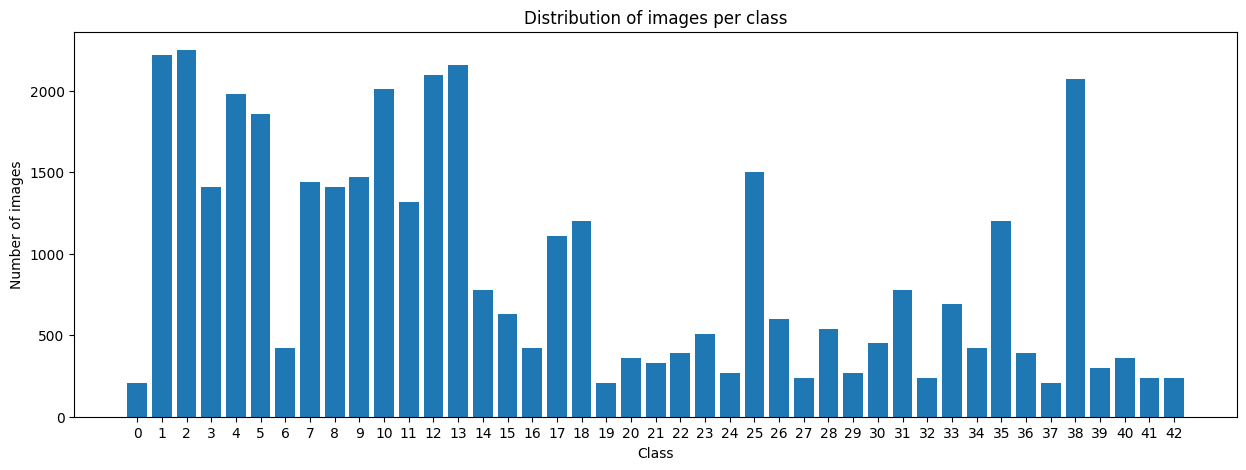

In [6]:
counts = train_df['ClassId'].value_counts().sort_index()

plt.figure(figsize=(15,5))
plt.bar(counts.index, counts.values)
plt.title("Distribution of images per class")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.xticks(counts.index)
plt.show()

In [7]:
class_names = {
    0:"Speed Limit (20Km/hr)", 1:"Speed Limit (30Km/hr)", 
    2:"Speed Limit (50Km/hr)", 3: "Speed Limit (60Km/hr)", 
    4: "Speed Limit (70Km/hr)", 5: "Speed Limit (80Km/hr)",
    6: "End of Speed Limit (80Km/hr)", 7: "Speed Limit (100Km/hr)", 
    8: "Speed Limit (120Km/hr)", 9: "No Passing", 
    10: "No Passing for trucks over 3.5 tons", 11: "Right of way", 
    12: "Priotity Road", 13: "Yeild right of way",
    14: "Stop", 15: "Prohibited for all vehicles",
    16: "Trucks and tractors over 3.5 tons prohibited", 17: "Entery prohibited",
    18: "Danger", 19: "Single curve left",
    20: "Single curve right", 21: "Double curve",
    22: "Rough road", 23: "Slippery road",
    24: "Road narrows", 25: "Construction side ahead",
    26: "Signal lights ahead", 27: "Pedestrian crosswalk ahead",
    28: "Children", 29: "Bicycle crossing",
    30: "Unexpected ice danger", 31: "Wild animal crossing",
    32: "End of restrection", 33: "Mandatory direction of travel right",
    34: "Mandatory direction of travel left", 35: "Mandatory direction of travel ahead",
    36: "Straight or right", 37: "Straight or left",
    38: "Keep right", 39: "Keep left",
    40: "Traffic circle", 41: "End of no passing zone cars",
    42: "End of no passing zone vehicle over 3.5 tons"
}

train_df["ClassName"] = train_df['ClassId'].map(class_names)
test_df["ClassName"] = test_df['ClassId'].map(class_names)

train_df.head()

train_df['ClassName'].value_counts()

ClassName
Speed Limit (50Km/hr)                           2250
Speed Limit (30Km/hr)                           2220
Yeild right of way                              2160
Priotity Road                                   2100
Keep right                                      2070
No Passing for trucks over 3.5 tons             2010
Speed Limit (70Km/hr)                           1980
Speed Limit (80Km/hr)                           1860
Construction side ahead                         1500
No Passing                                      1470
Speed Limit (100Km/hr)                          1440
Speed Limit (60Km/hr)                           1410
Speed Limit (120Km/hr)                          1410
Right of way                                    1320
Mandatory direction of travel ahead             1200
Danger                                          1200
Entery prohibited                               1110
Stop                                             780
Wild animal crossing                

In [8]:
print(f"Maximum images per class: {train_df['ClassName'].value_counts().max()} (Class: {train_df['ClassName'].value_counts().idxmax()})")
print(f"Minimum images per class: {train_df['ClassName'].value_counts().min()} (Class: {train_df['ClassName'].value_counts().idxmin()})")
print(f"Average images per class: {train_df['ClassName'].value_counts().mean():.1f}")

Maximum images per class: 2250 (Class: Speed Limit (50Km/hr))
Minimum images per class: 210 (Class: Speed Limit (20Km/hr))
Average images per class: 911.8


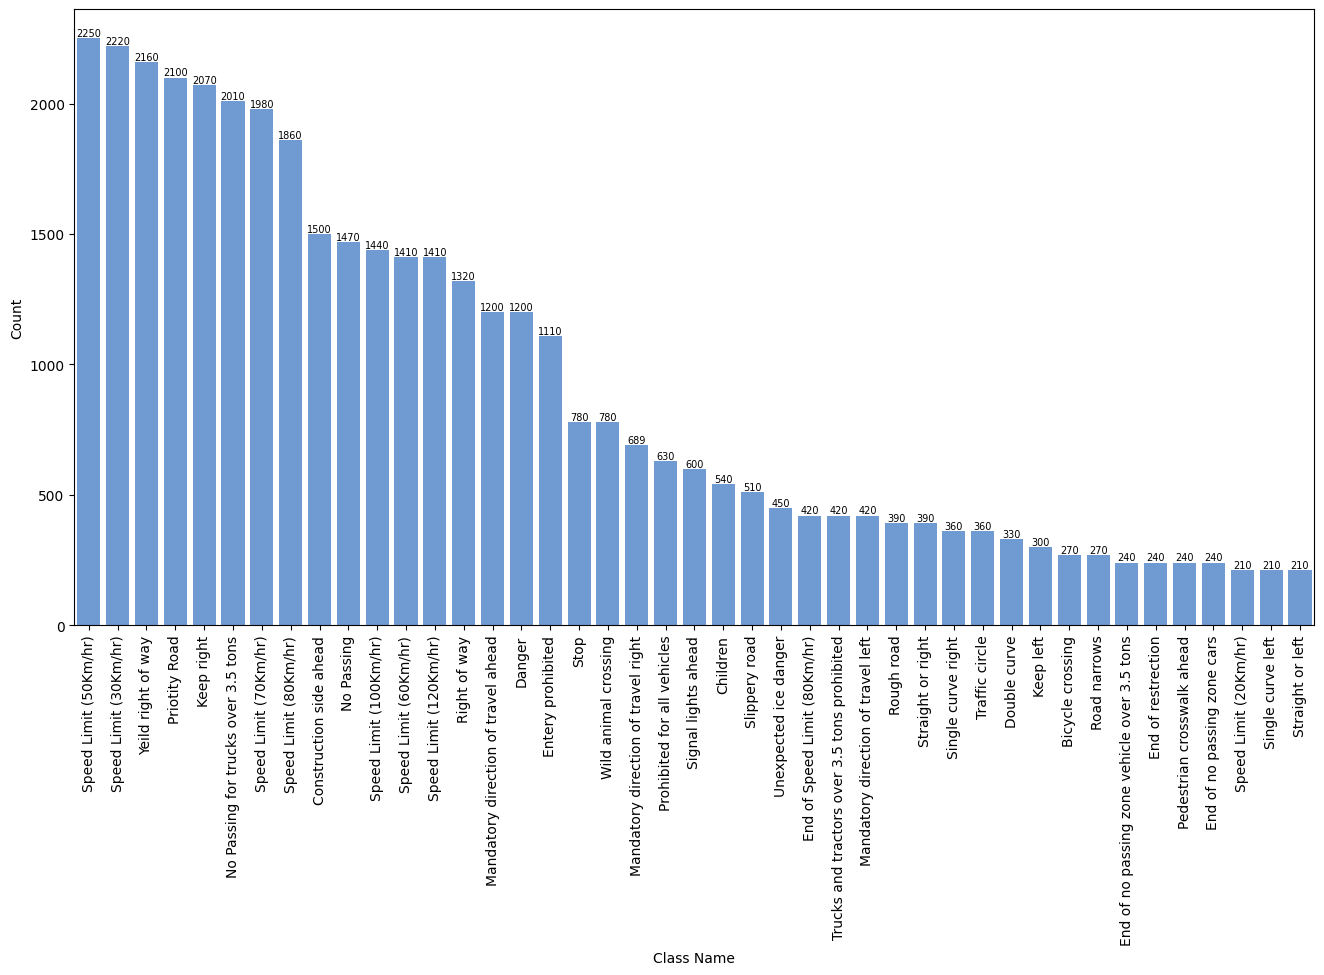

In [9]:
plt.figure(figsize=(16, 8))
ax = sns.countplot(data=train_df, x="ClassName", order=train_df["ClassName"].value_counts().index, color="#5F98E2")
plt.xlabel("Class Name")
plt.ylabel("Count")
plt.xticks(rotation=90)
for container in ax.containers:
    ax.bar_label(container, fontsize=7)
plt.show()

In [44]:
def random_image_generator(class_id):
    if class_id < 0 or class_id > 42:
        raise ValueError("class_id must be between 0 and 42 inclusive.")

    folder = os.path.join(train_img_path, str(class_id))
    image_files = [f for f in os.listdir(folder) if not f.startswith(".")]

    filename = random.choice(image_files)
    sample_path = os.path.join(folder, filename)

    img = Image.open(sample_path)

    return img

Now we can randomise images that are in our training dataset. This will help familiarise the user with the types of images we are dealing with.

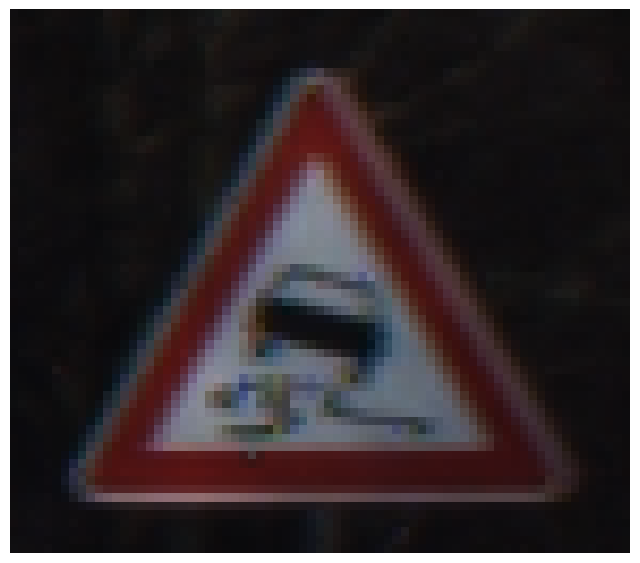

In [45]:
random_class = random.randint(0, 42)
img1 = random_image_generator(random_class)

plt.figure(figsize=(8,8))
plt.imshow(img1)
plt.axis("off")
plt.show()

In [12]:
def get_image_paths(filepath: str) -> Tuple[List[str], List[str]]:
    image_paths = []
    class_labels = []

    for root, _, files in os.walk(filepath):
        for filename in files:
            if filename.lower().endswith((".png", ".jpg", ".jpeg", ".ppm", ".bmp")):
                full_path = os.path.join(root, filename)
                image_paths.append(full_path)

                # grab class folder name
                class_id = os.path.basename(root)
                class_labels.append(class_id)

    return image_paths, class_labels

train_image_paths, train_labels = get_image_paths(train_img_path)

In [13]:
def print_sample_images(n, cols):
    total = len(train_image_paths)
    num_images = min(n*cols, total)

    if num_images >= total:
        print("WARNING: Total images exceed available images. Returning all available images. This may take a while.")

    if (n, cols) >= (100, 5):
        print("WARNING: You are attempting to plot many images. This may take a while.")

    plt.figure(figsize=(cols*3, n*3))

    for i, k in enumerate(random.sample(range(total), num_images), start=1):
        img = plt.imread(train_image_paths[k])
        plt.subplot(n, cols, i)
        plt.imshow(img)
        plt.title(class_names[int(train_labels[k])])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

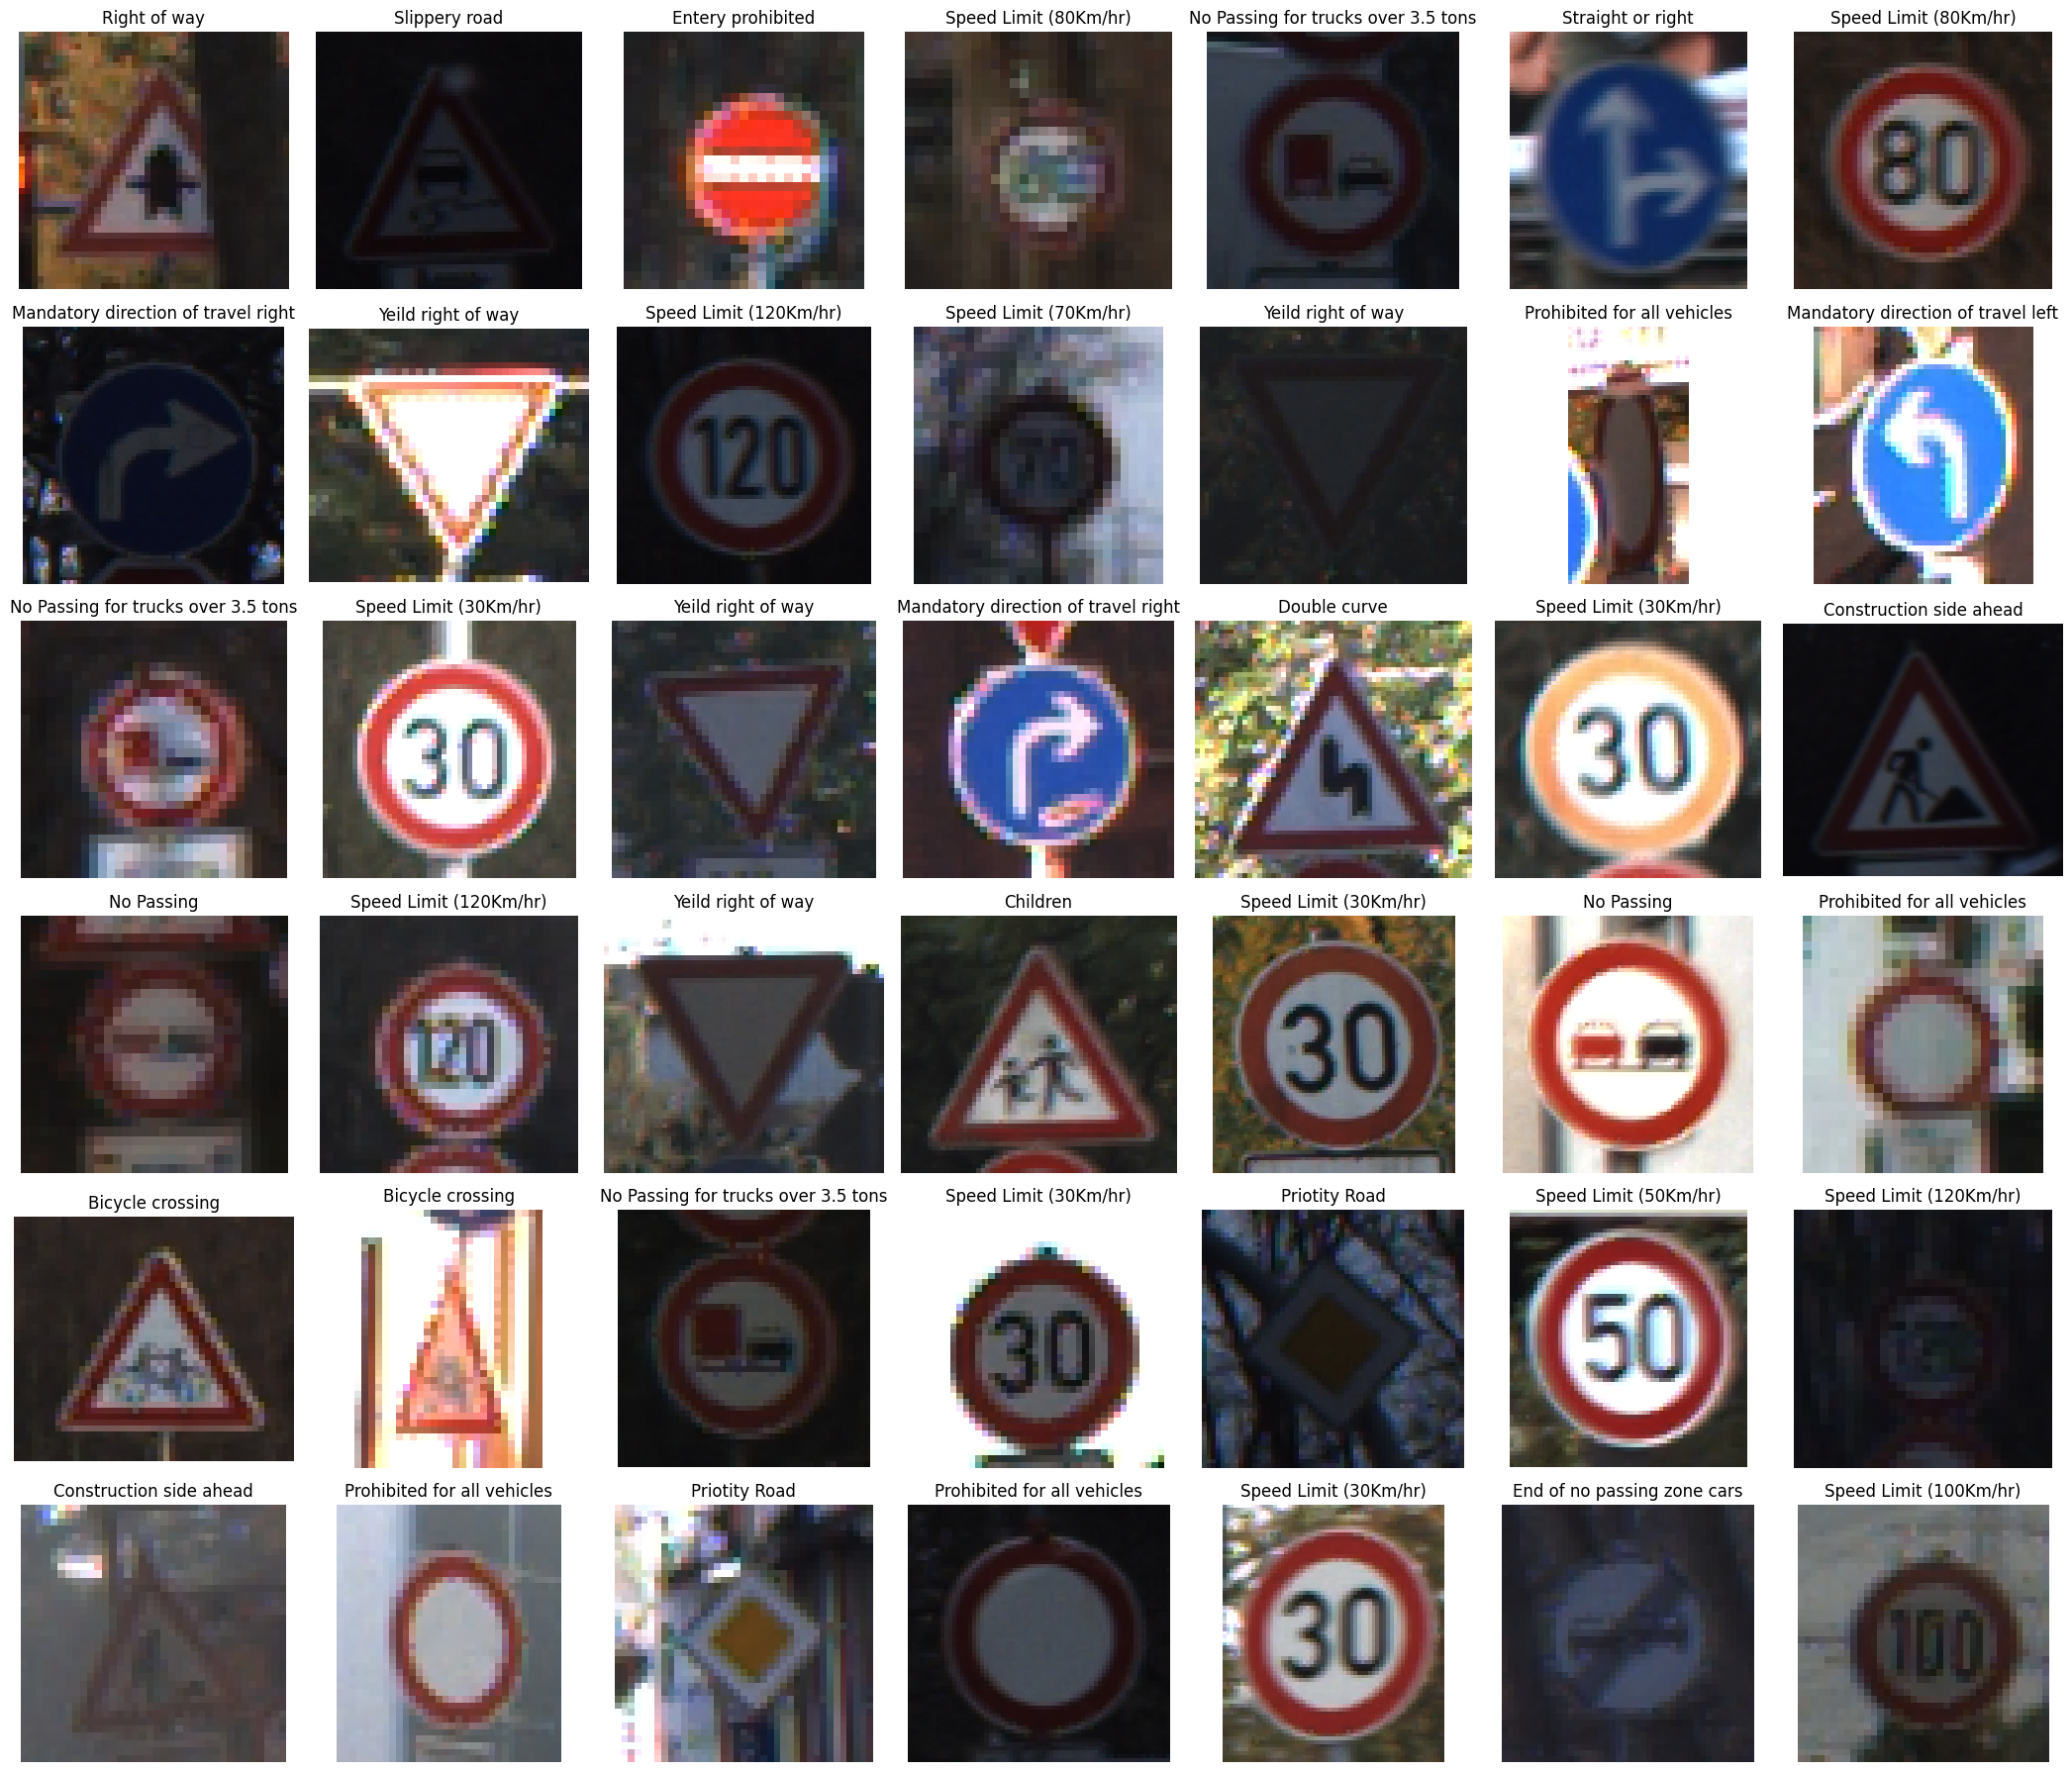

In [14]:
print_sample_images(6,7)

In [15]:
def random_sample_images_per_class():
    for c in sorted(train_df['ClassId'].unique()):
        folder = os.path.join(train_img_path, str(c))
        filenames = os.listdir(folder)
        
        sample_files = random.sample(filenames, min(5, len(filenames)))
        
        # Plot images
        plt.figure(figsize=(15, 3))
        class_name = class_names.get(c, f"Class {c}")
        plt.suptitle(f"{class_name} (Class {c})", fontsize=16)
        
        for i, f in enumerate(sample_files):
            img_path = os.path.join(folder, f)
            img = Image.open(img_path)
            
            plt.subplot(1, 5, i+1)
            plt.imshow(img)
            plt.axis("off")
        
        plt.show()

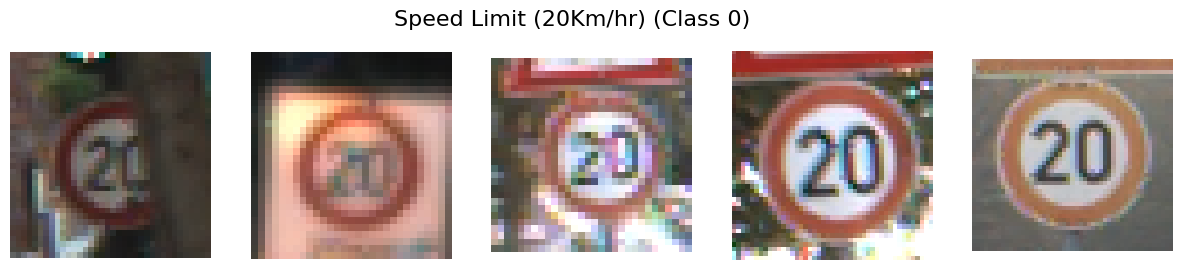

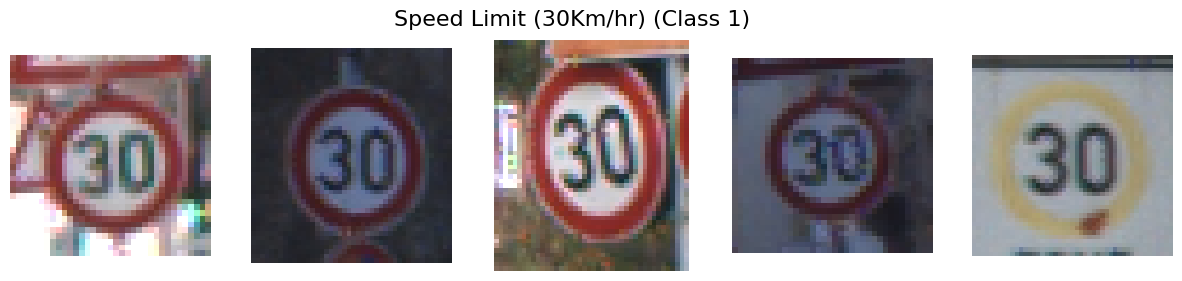

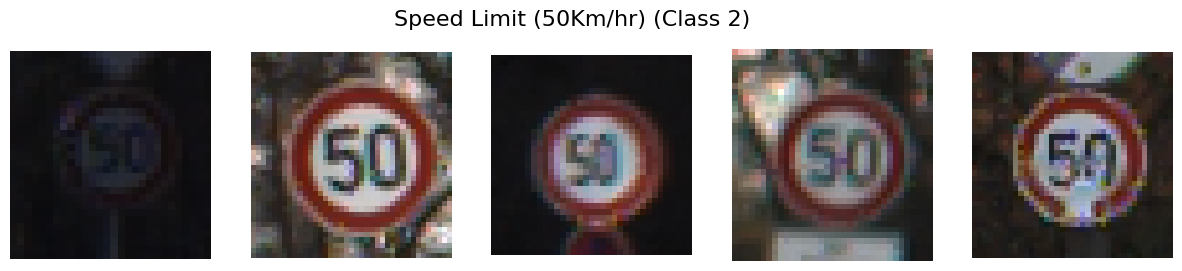

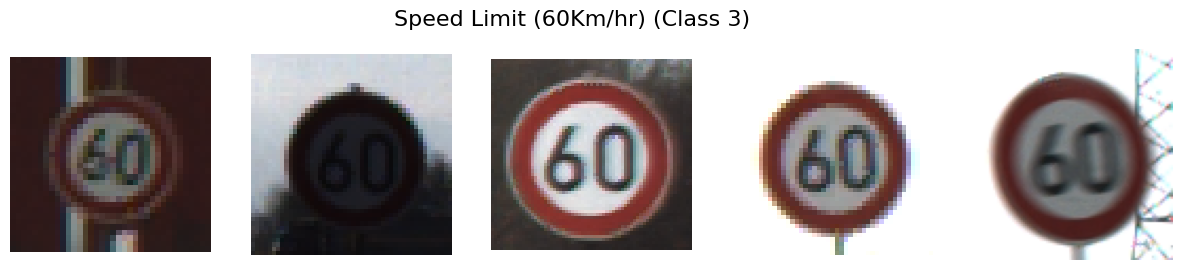

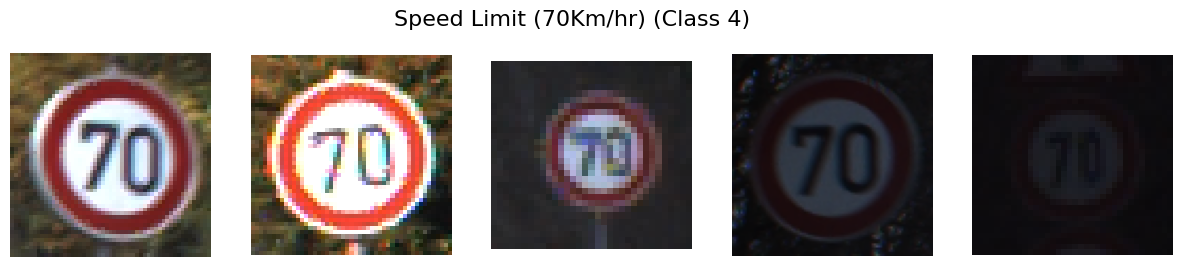

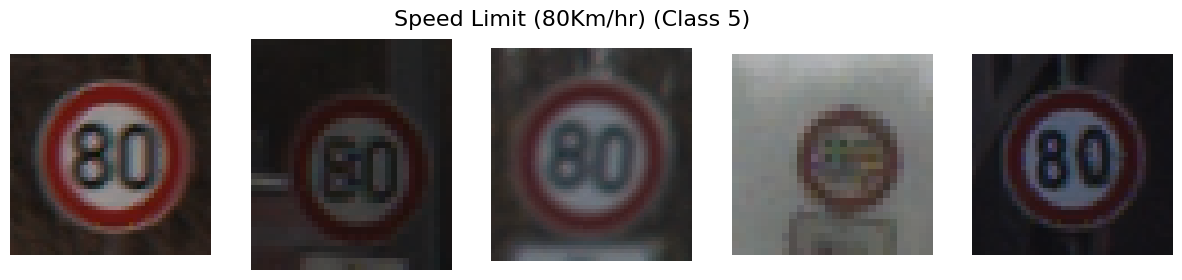

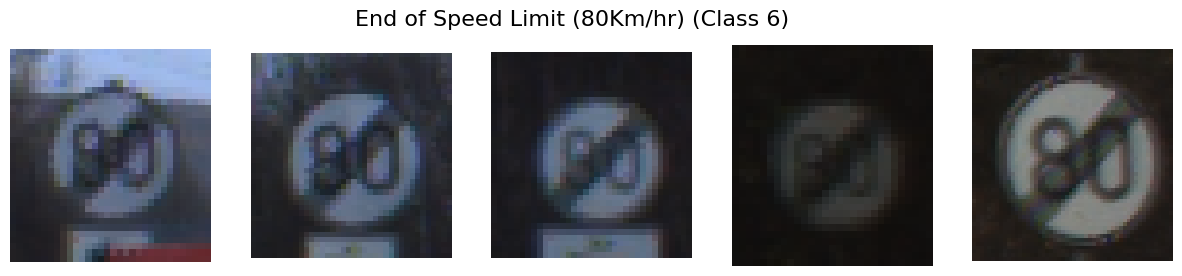

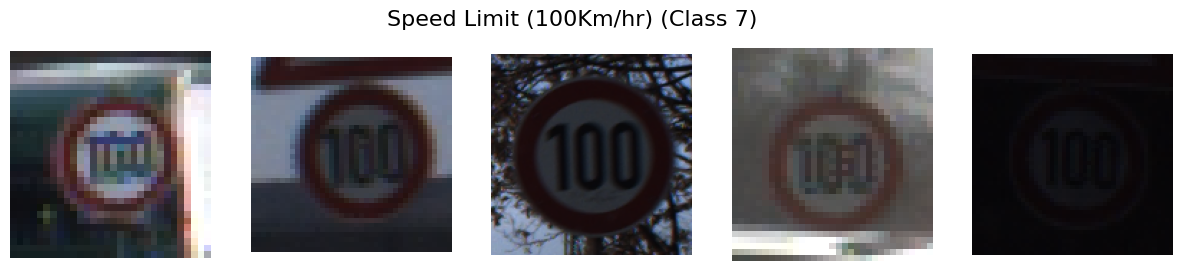

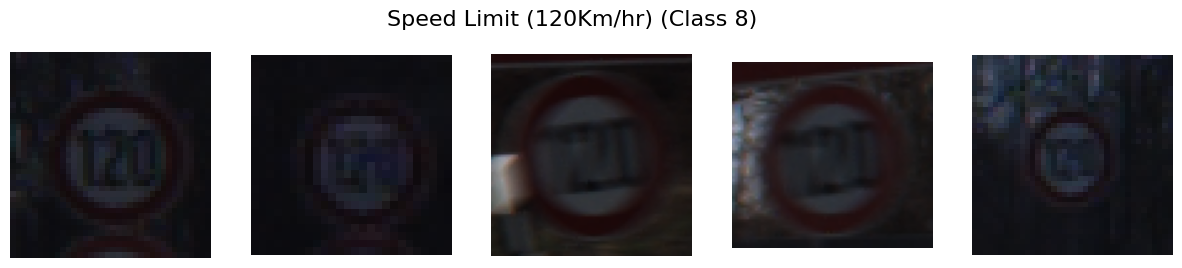

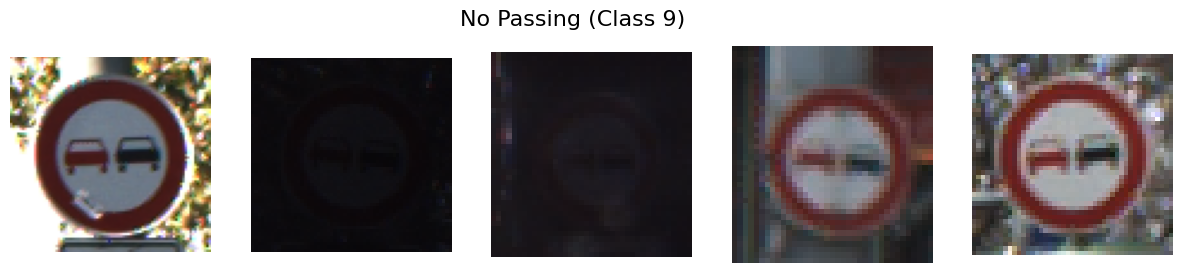

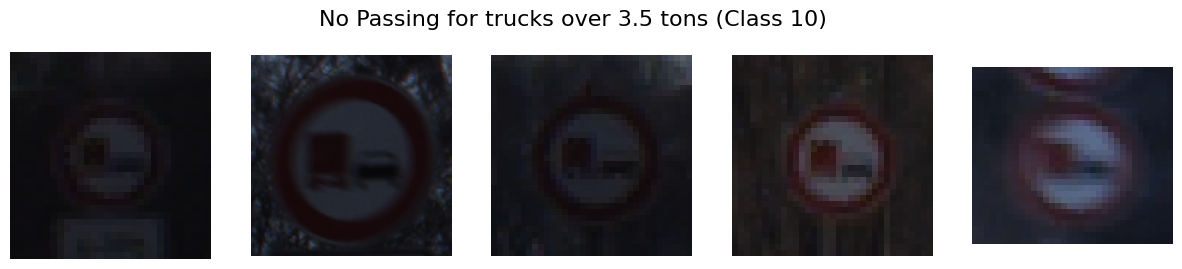

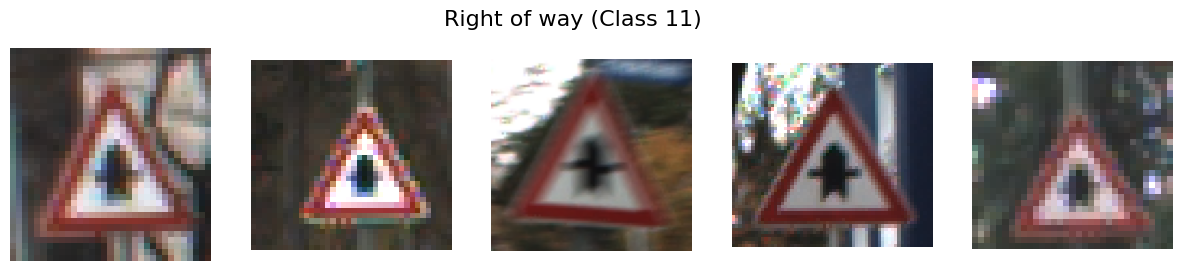

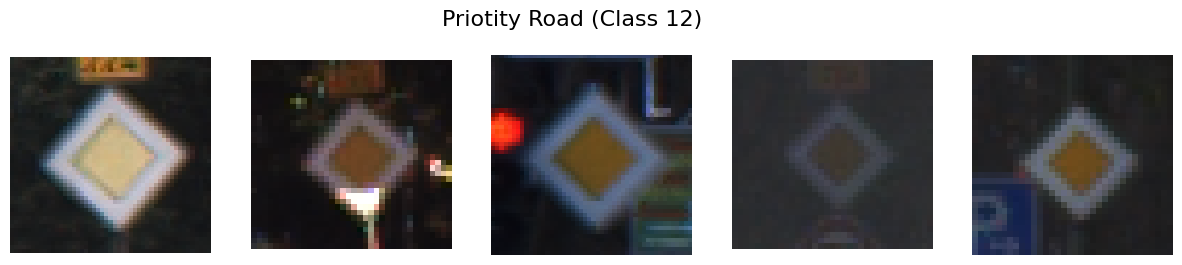

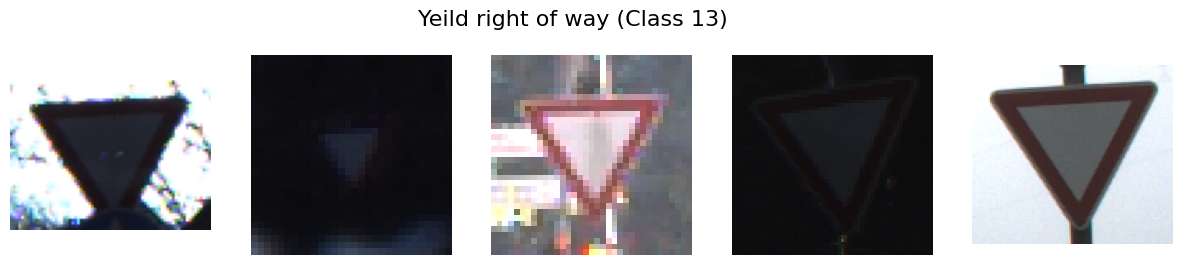

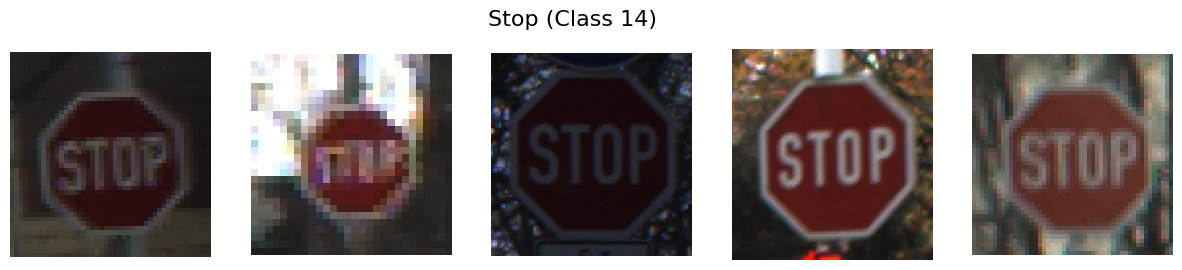

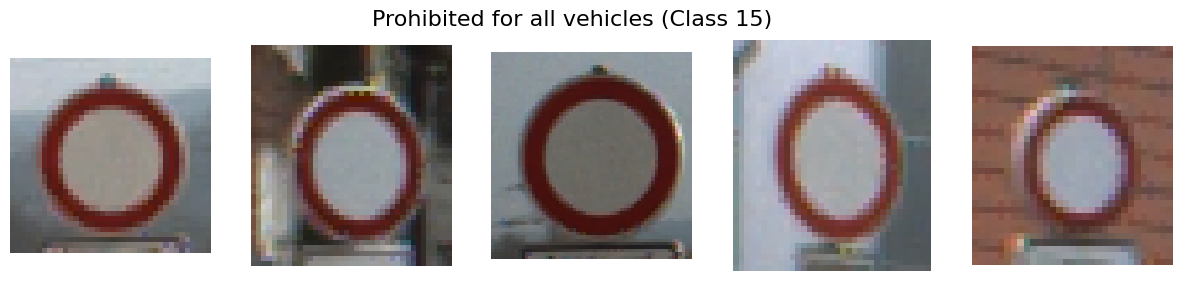

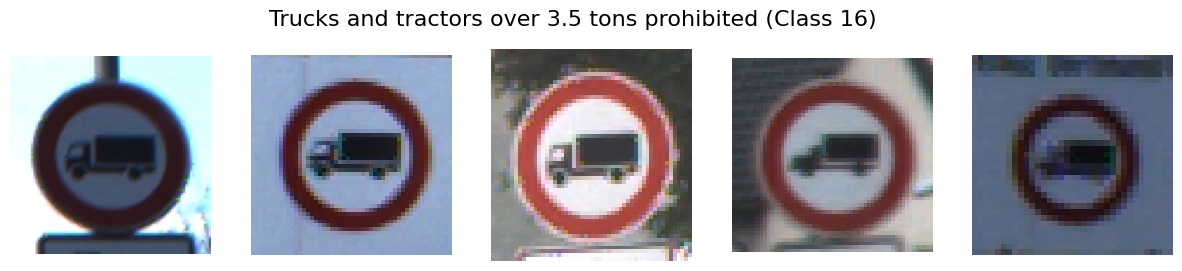

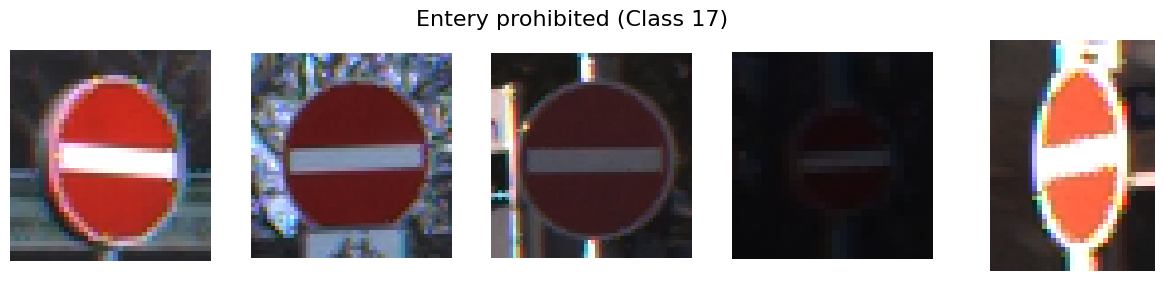

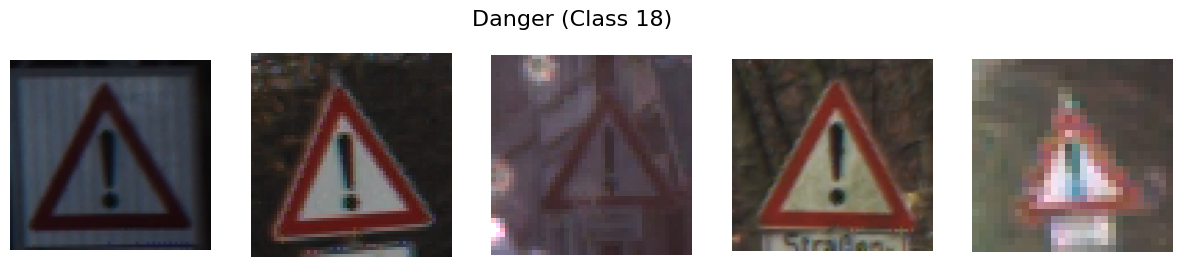

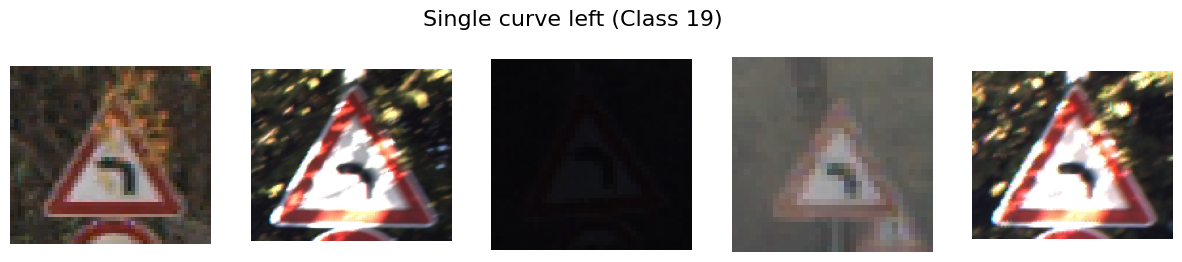

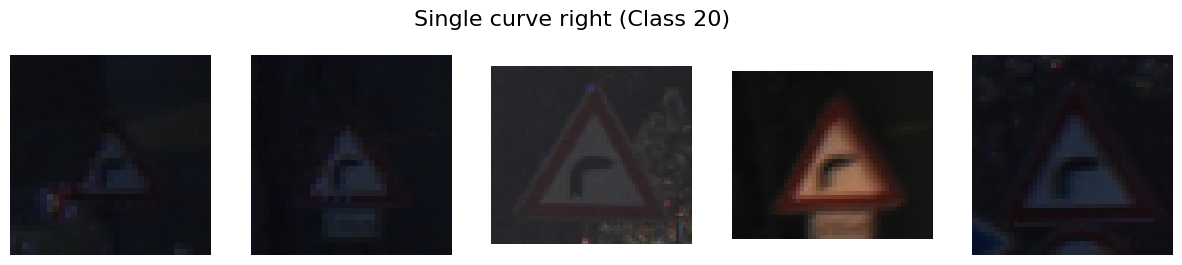

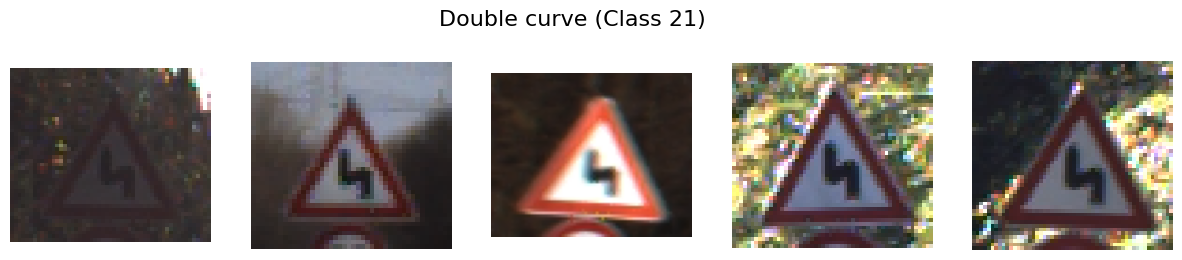

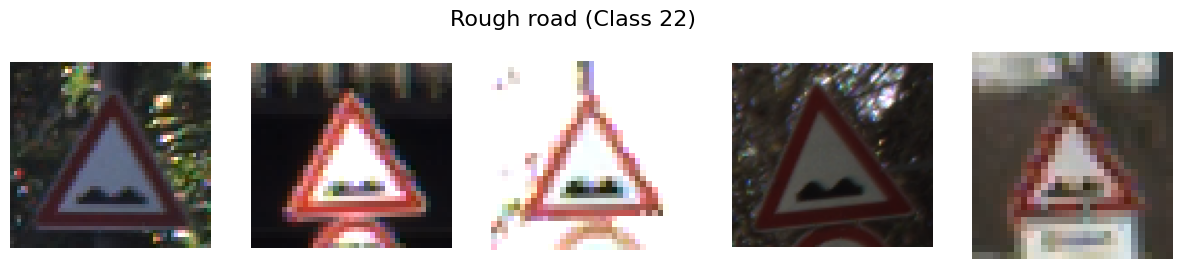

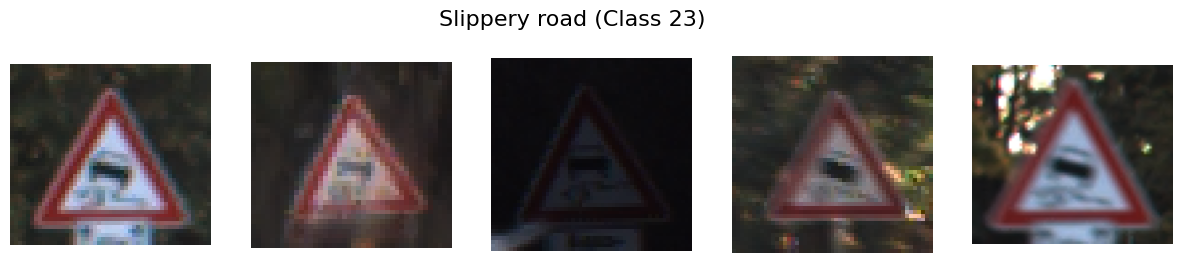

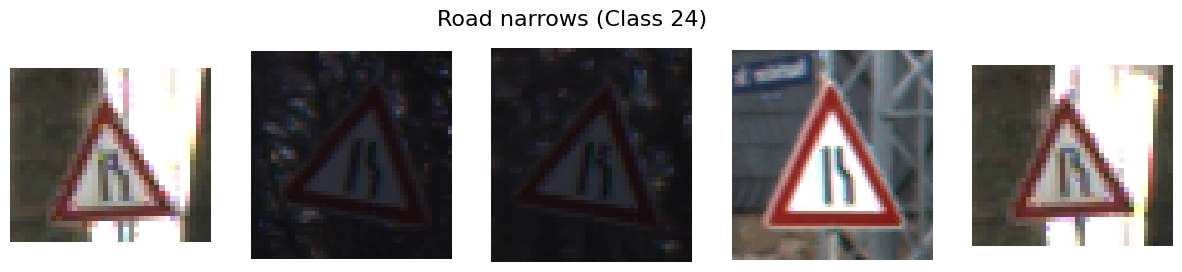

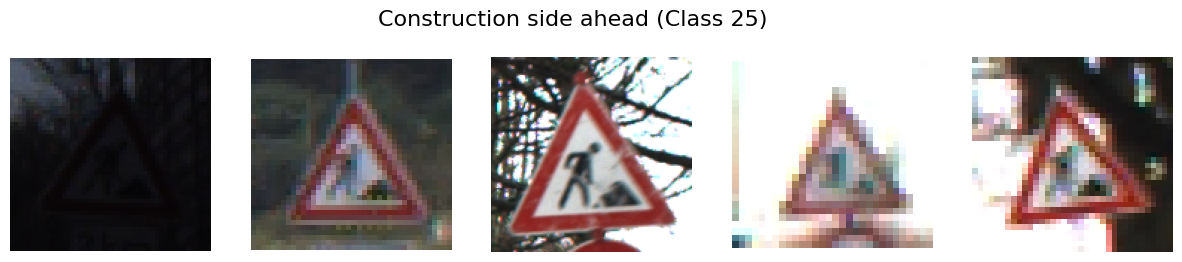

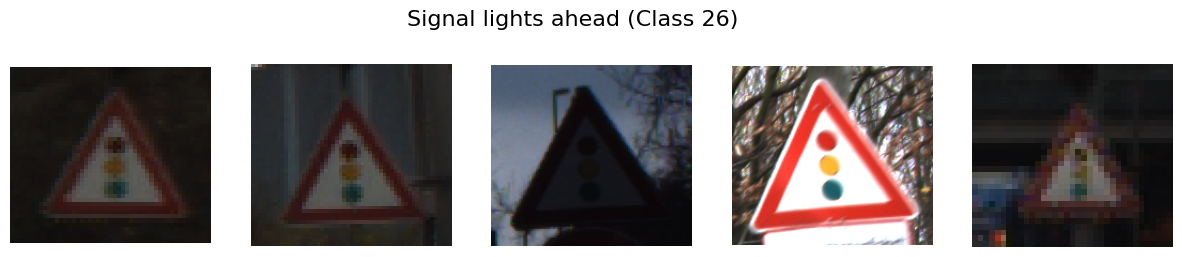

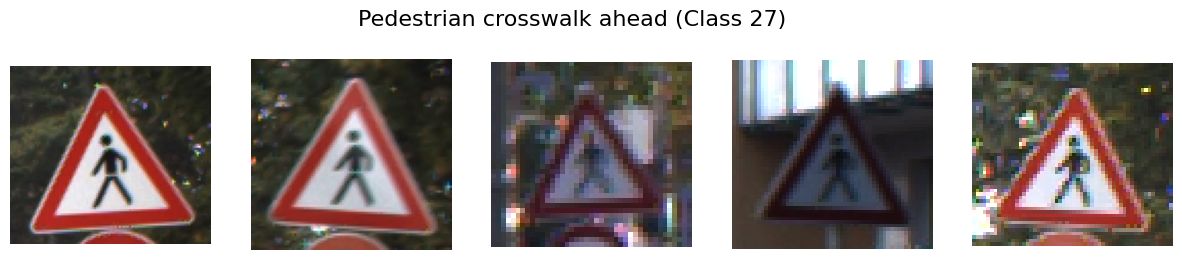

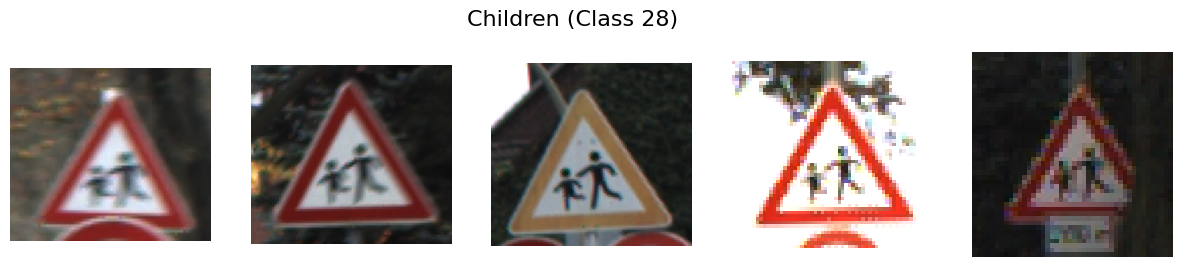

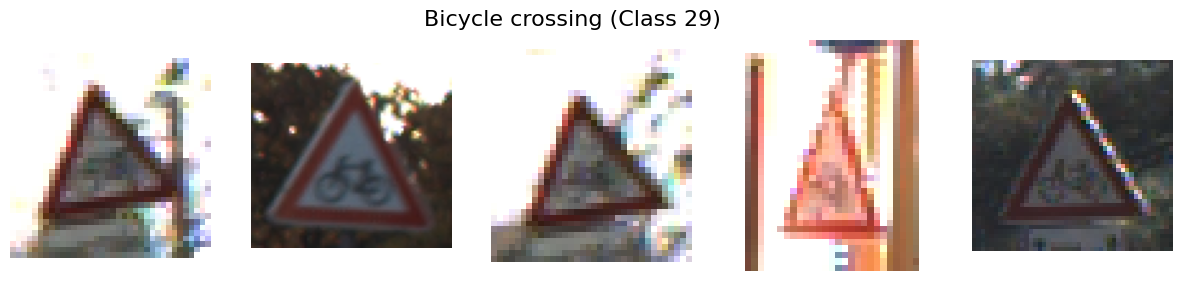

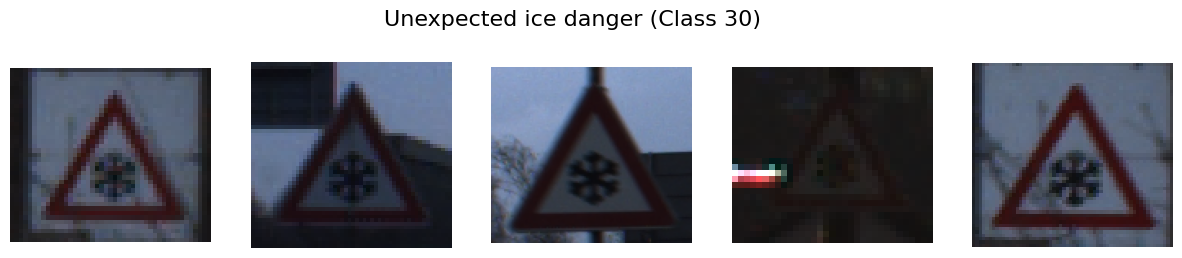

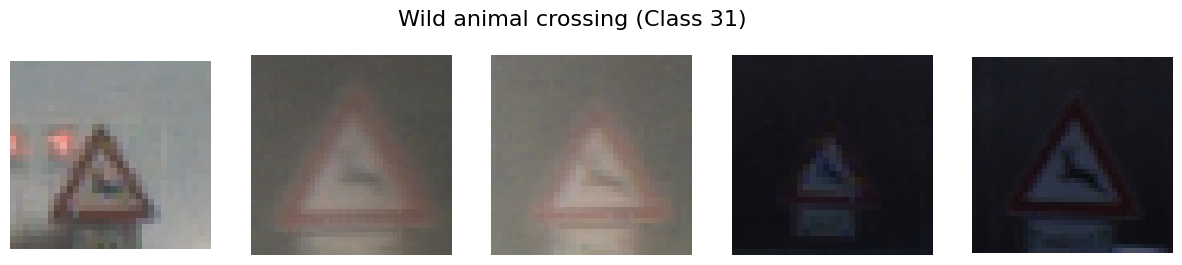

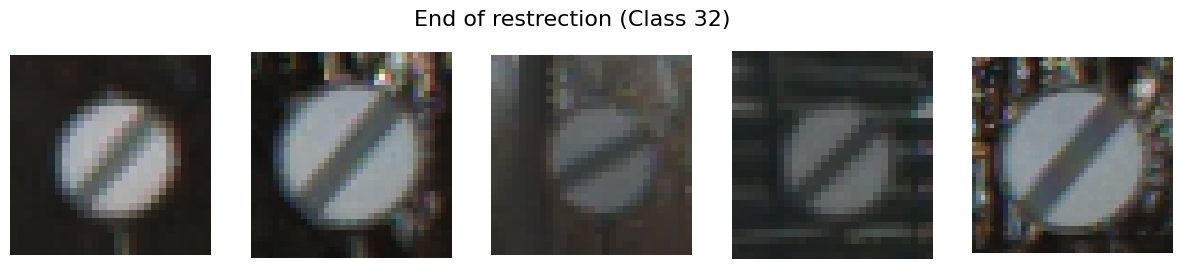

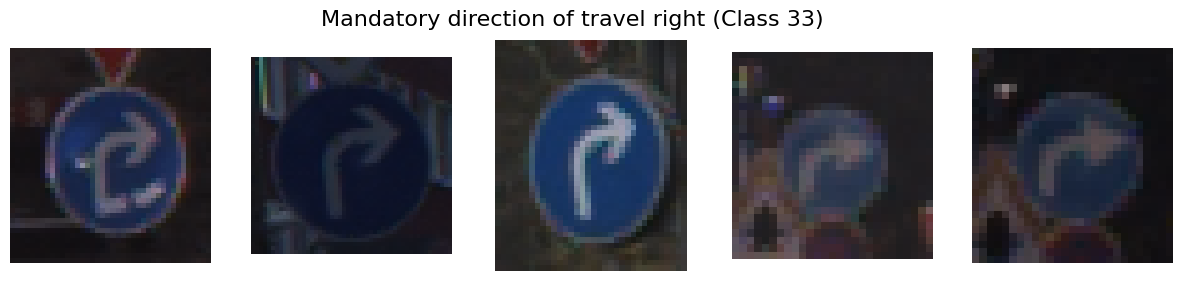

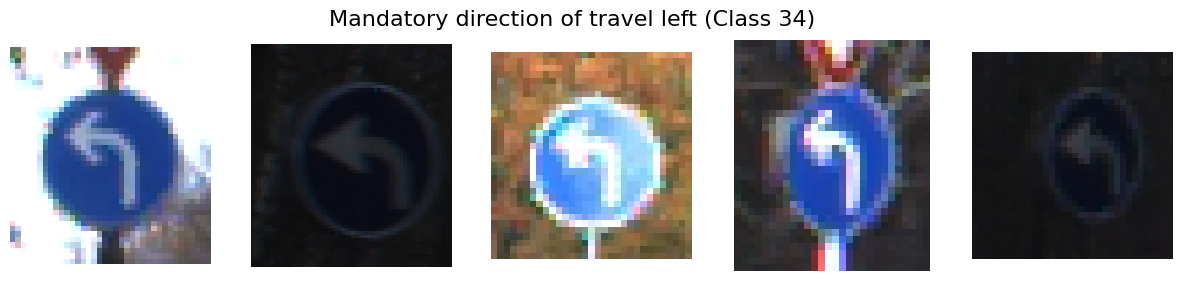

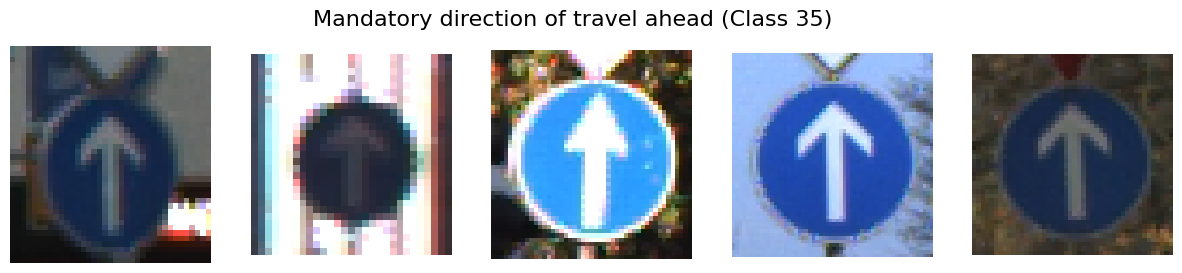

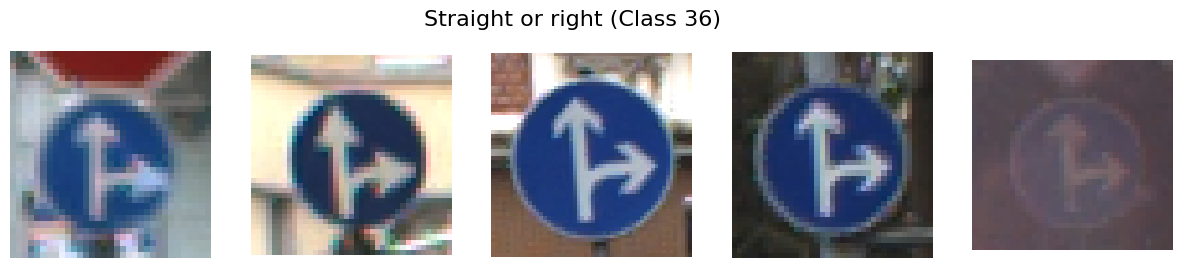

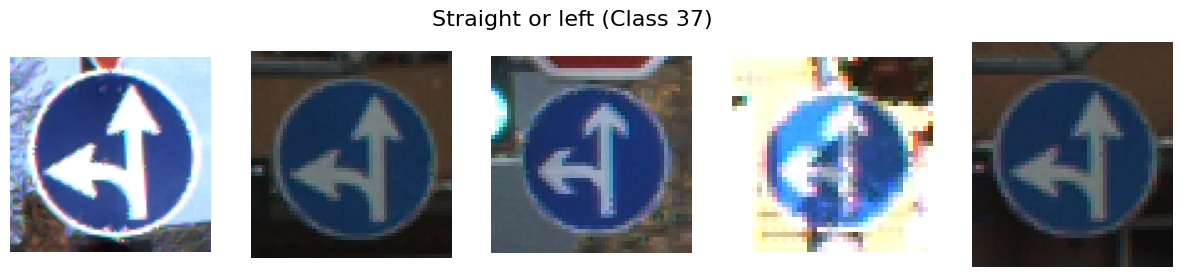

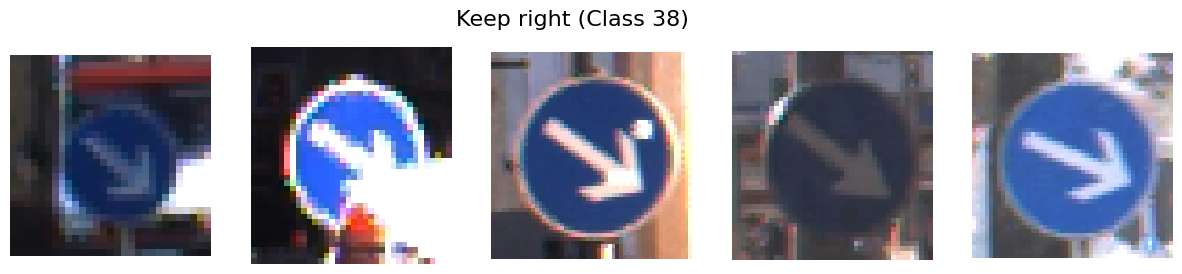

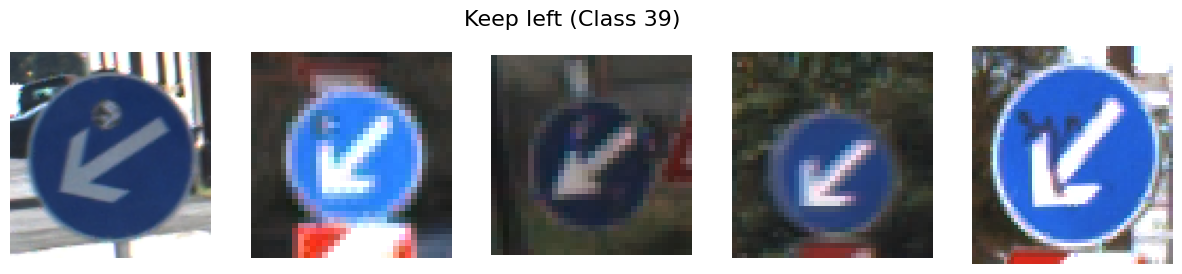

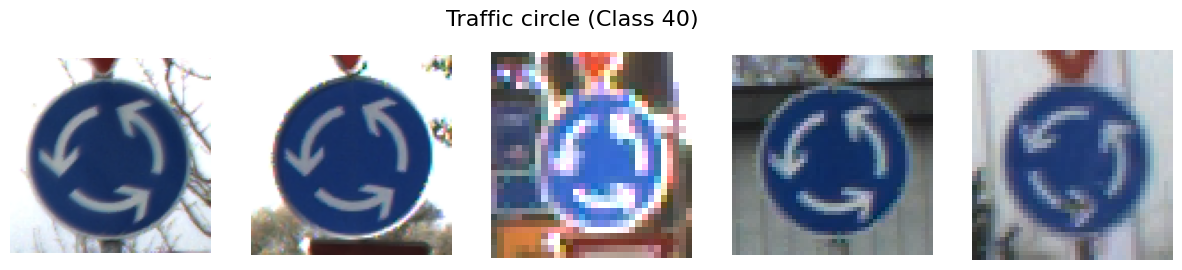

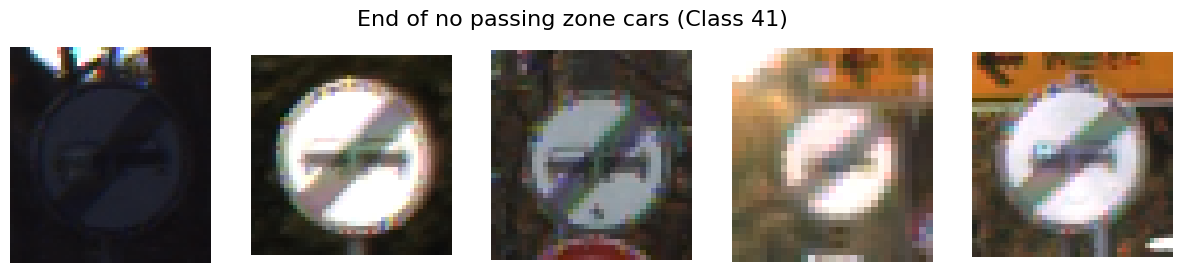

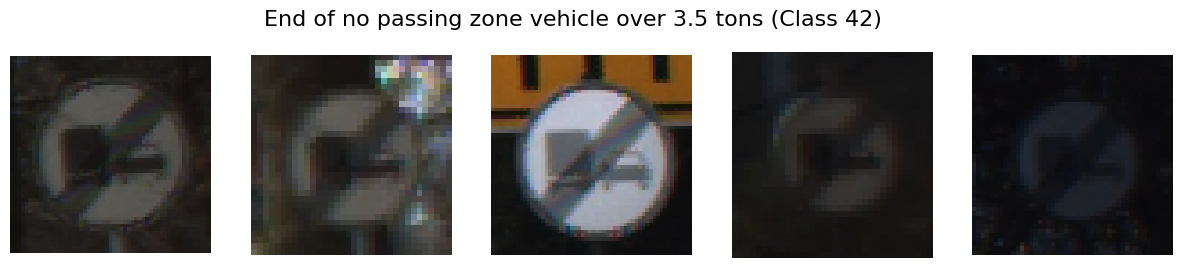

In [16]:
random_sample_images_per_class()

In [17]:
def resolutions(image_paths, max_images=None):
    resolutions = []
    for path in image_paths[:max_images]:
        with Image.open(path) as img:
            resolutions.append(img.size)
    return resolutions

resolutions(train_image_paths, max_images=5000)

[(29, 30),
 (30, 30),
 (30, 30),
 (31, 31),
 (30, 32),
 (31, 31),
 (33, 34),
 (34, 35),
 (33, 34),
 (36, 36),
 (35, 36),
 (37, 38),
 (37, 38),
 (40, 39),
 (41, 42),
 (44, 44),
 (46, 44),
 (47, 48),
 (50, 48),
 (53, 51),
 (57, 54),
 (59, 58),
 (63, 61),
 (70, 70),
 (76, 76),
 (85, 86),
 (97, 97),
 (108, 110),
 (124, 127),
 (144, 148),
 (29, 30),
 (30, 30),
 (30, 29),
 (31, 31),
 (31, 31),
 (32, 32),
 (33, 34),
 (34, 33),
 (33, 33),
 (34, 33),
 (36, 35),
 (35, 36),
 (36, 36),
 (36, 36),
 (37, 36),
 (38, 38),
 (38, 39),
 (39, 41),
 (40, 41),
 (42, 43),
 (43, 43),
 (45, 45),
 (45, 47),
 (47, 48),
 (49, 49),
 (50, 52),
 (53, 54),
 (55, 56),
 (57, 59),
 (59, 61),
 (27, 26),
 (27, 28),
 (27, 28),
 (30, 29),
 (30, 29),
 (31, 31),
 (30, 30),
 (32, 31),
 (31, 32),
 (34, 33),
 (34, 34),
 (35, 35),
 (38, 37),
 (39, 39),
 (40, 39),
 (41, 41),
 (44, 44),
 (46, 45),
 (48, 47),
 (51, 50),
 (52, 52),
 (55, 55),
 (59, 59),
 (62, 63),
 (69, 70),
 (74, 75),
 (83, 85),
 (92, 95),
 (107, 108),
 (122, 124),


In [18]:
def reso_counter(image_paths, max_images=None):
    res_counter = Counter(resolutions(image_paths, max_images))
    print("Top resolutions (Width x Height : Count):")
    for (w, h), count in res_counter.most_common(10):
        print(f"{w} x {h} : {count}")

reso_counter(train_image_paths, max_images=5000)

Top resolutions (Width x Height : Count):
37 x 37 : 62
33 x 34 : 56
31 x 31 : 55
36 x 36 : 55
38 x 38 : 52
35 x 35 : 52
30 x 30 : 50
34 x 34 : 50
34 x 33 : 48
39 x 39 : 47


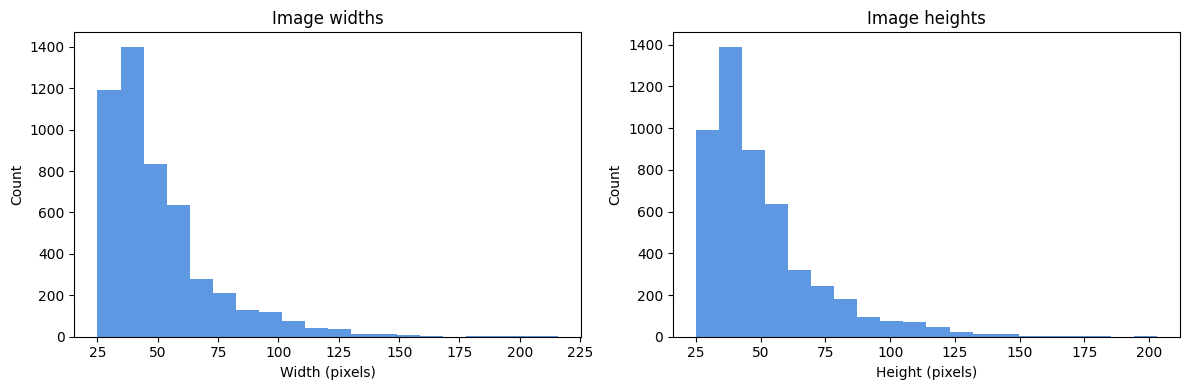

In [19]:
def reso_histogram(image_paths, max_images=None):
    widths, heights = zip(*resolutions(image_paths, max_images))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.hist(widths, bins=20, color="#5F98E2")
    ax1.set(xlabel="Width (pixels)", ylabel="Count", title="Image widths")
    ax2.hist(heights, bins=20, color="#5F98E2")
    ax2.set(xlabel="Height (pixels)", ylabel="Count", title="Image heights")
    plt.tight_layout()
    plt.show()

    return widths, heights

widths, heights = reso_histogram(train_image_paths, max_images=5000)

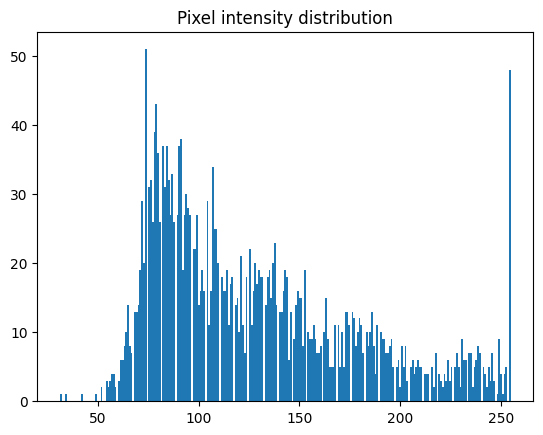

In [20]:
img = np.array(Image.open(train_image_paths[0])) 
plt.hist(img.ravel(), bins=255)
plt.title("Pixel intensity distribution")
plt.show()

In [21]:
def random_pixel_values():
    random.seed(42)
    pixel_values = []

    # take up to 10 random images from each class
    for c in sorted(train_df['ClassId'].unique()):
        folder = os.path.join(train_img_path, str(c))
        filenames = os.listdir(folder)
        sample_files = random.sample(filenames, min(10, len(filenames)))
        
        for f in sample_files:
            img = Image.open(os.path.join(folder, f)).convert('RGB')
            img_array = np.array(img)
            pixel_values.extend(img_array.flatten())

    return pixel_values

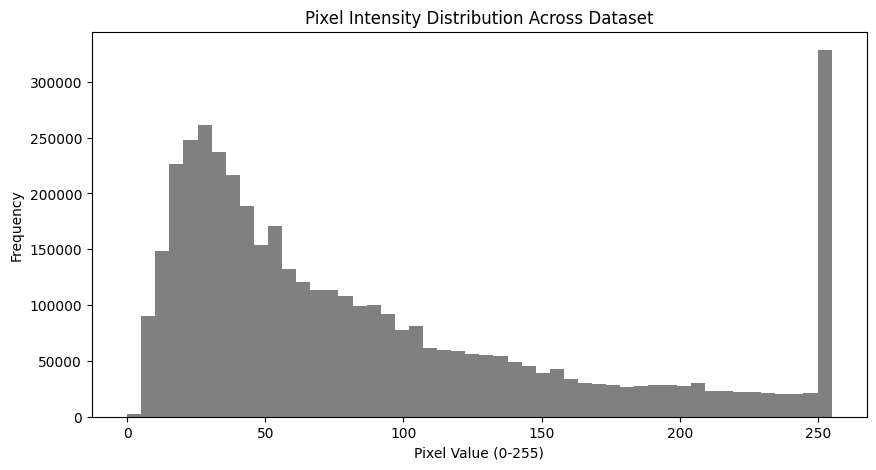

In [22]:
# Plot histogram
plt.figure(figsize=(10,5))
plt.hist(random_pixel_values(), bins=50, color='gray')
plt.title("Pixel Intensity Distribution Across Dataset")
plt.xlabel("Pixel Value (0-255)")
plt.ylabel("Frequency")
plt.show()

In [23]:
pixels = np.array(random_pixel_values())

# Compute more statistics
print("Min pixel value:", np.min(pixels))
print("25th percentile:", np.percentile(pixels, 25))
print("Median (50th percentile):", np.median(pixels))
print("75th percentile:", np.percentile(pixels, 75))
print("Max pixel value:", np.max(pixels))
print("Mean pixel value:", np.mean(pixels))
print("Standard deviation:", np.std(pixels))

Min pixel value: 0
25th percentile: 32.0
Median (50th percentile): 65.0
75th percentile: 128.0
Max pixel value: 255
Mean pixel value: 90.23437089755264
Standard deviation: 73.53056229613492


In [27]:
random.seed(42)
np.random.seed(42)

def augment_image(img):
    # Rotation ±10°
    angle = random.uniform(-10, 10)
    img = img.rotate(angle)

    # Random horizontal and vertical shift (10% max)
    max_shift_x = int(0.1 * img.width)
    max_shift_y = int(0.1 * img.height)
    shift_x = random.randint(-max_shift_x, max_shift_x)
    shift_y = random.randint(-max_shift_y, max_shift_y)
    img = img.transform(img.size, Image.AFFINE, (1, 0, shift_x, 0, 1, shift_y))

    # Random zoom/crop ±10%
    zoom_factor = random.uniform(0.9, 1.1)
    w, h = img.size
    new_w, new_h = int(w * zoom_factor), int(h * zoom_factor)
    img = img.resize((new_w, new_h), Image.BILINEAR)
    img = img.crop((0, 0, w, h))  # crop or pad back to original size

    # Brightness adjustment ±20%
    enhancer = ImageEnhance.Brightness(img)
    factor = random.uniform(0.8, 1.2)
    img = enhancer.enhance(factor)

    return img

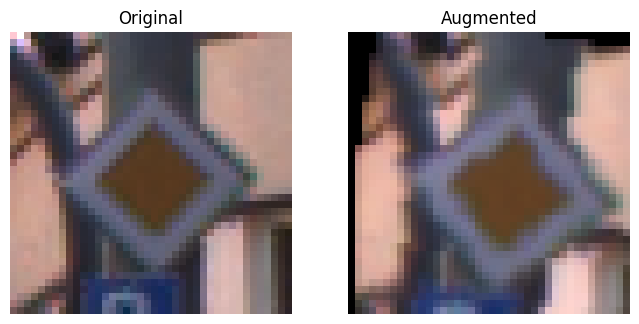

In [46]:
image_number = random.randint(0, 42)

img1 = random_image_generator(image_number)

aug_img1 = augment_image(img1)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(aug_img1)
plt.title("Augmented")
plt.axis("off")
plt.show()

In [36]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df["ClassId"],
    random_state=42
)

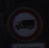

In [54]:
random_image_generator(16)

See that train dataset has been reduced to 80% of inital length, as we apportioned the remaining 20% to validation set.

Will follow up with evaluation, importing Neva and Gracie's Models